# **Bottle-gourd Disease Detection using custom CNN models** 

In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-m4vuf2lk
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-m4vuf2lk
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
import zipfile
import os
from tqdm import tqdm  # Import tqdm for progress bars

## Pre-Processing and Load the Dataset

In [3]:
# Define transformations with potential augmentations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      
    transforms.RandomHorizontalFlip(),     
    transforms.ToTensor(),                  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),         
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/input/bottle-gourd/Bottle gourd", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
print(dataset.class_to_idx)
# Output: {'anthracnose': 0, 'downey mildew': 1, 'fresh leaf': 2}

{'Anthracnose': 0, 'Downey mildew': 1, 'Fresh leaf': 2}


['Anthracnose', 'Downey mildew', 'Fresh leaf']
3


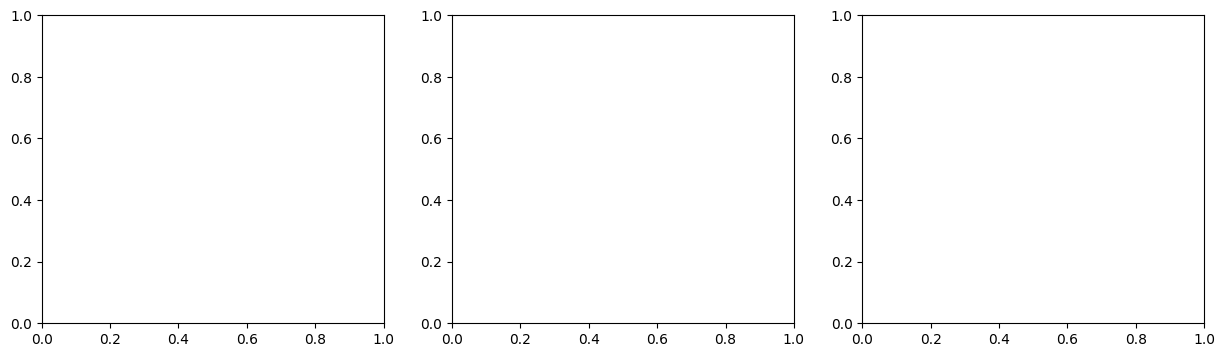

In [5]:
class_names = dataset.classes
print(class_names)
num_classes = len(class_names)
print(num_classes)
fig, axs = plt.subplots(1, num_classes, figsize=(15, 4))